# Chapter 8: Simulation, Scenarios and Stress Testing #

## Code segment 8.1  
Figure 8.1 in Section 8.1

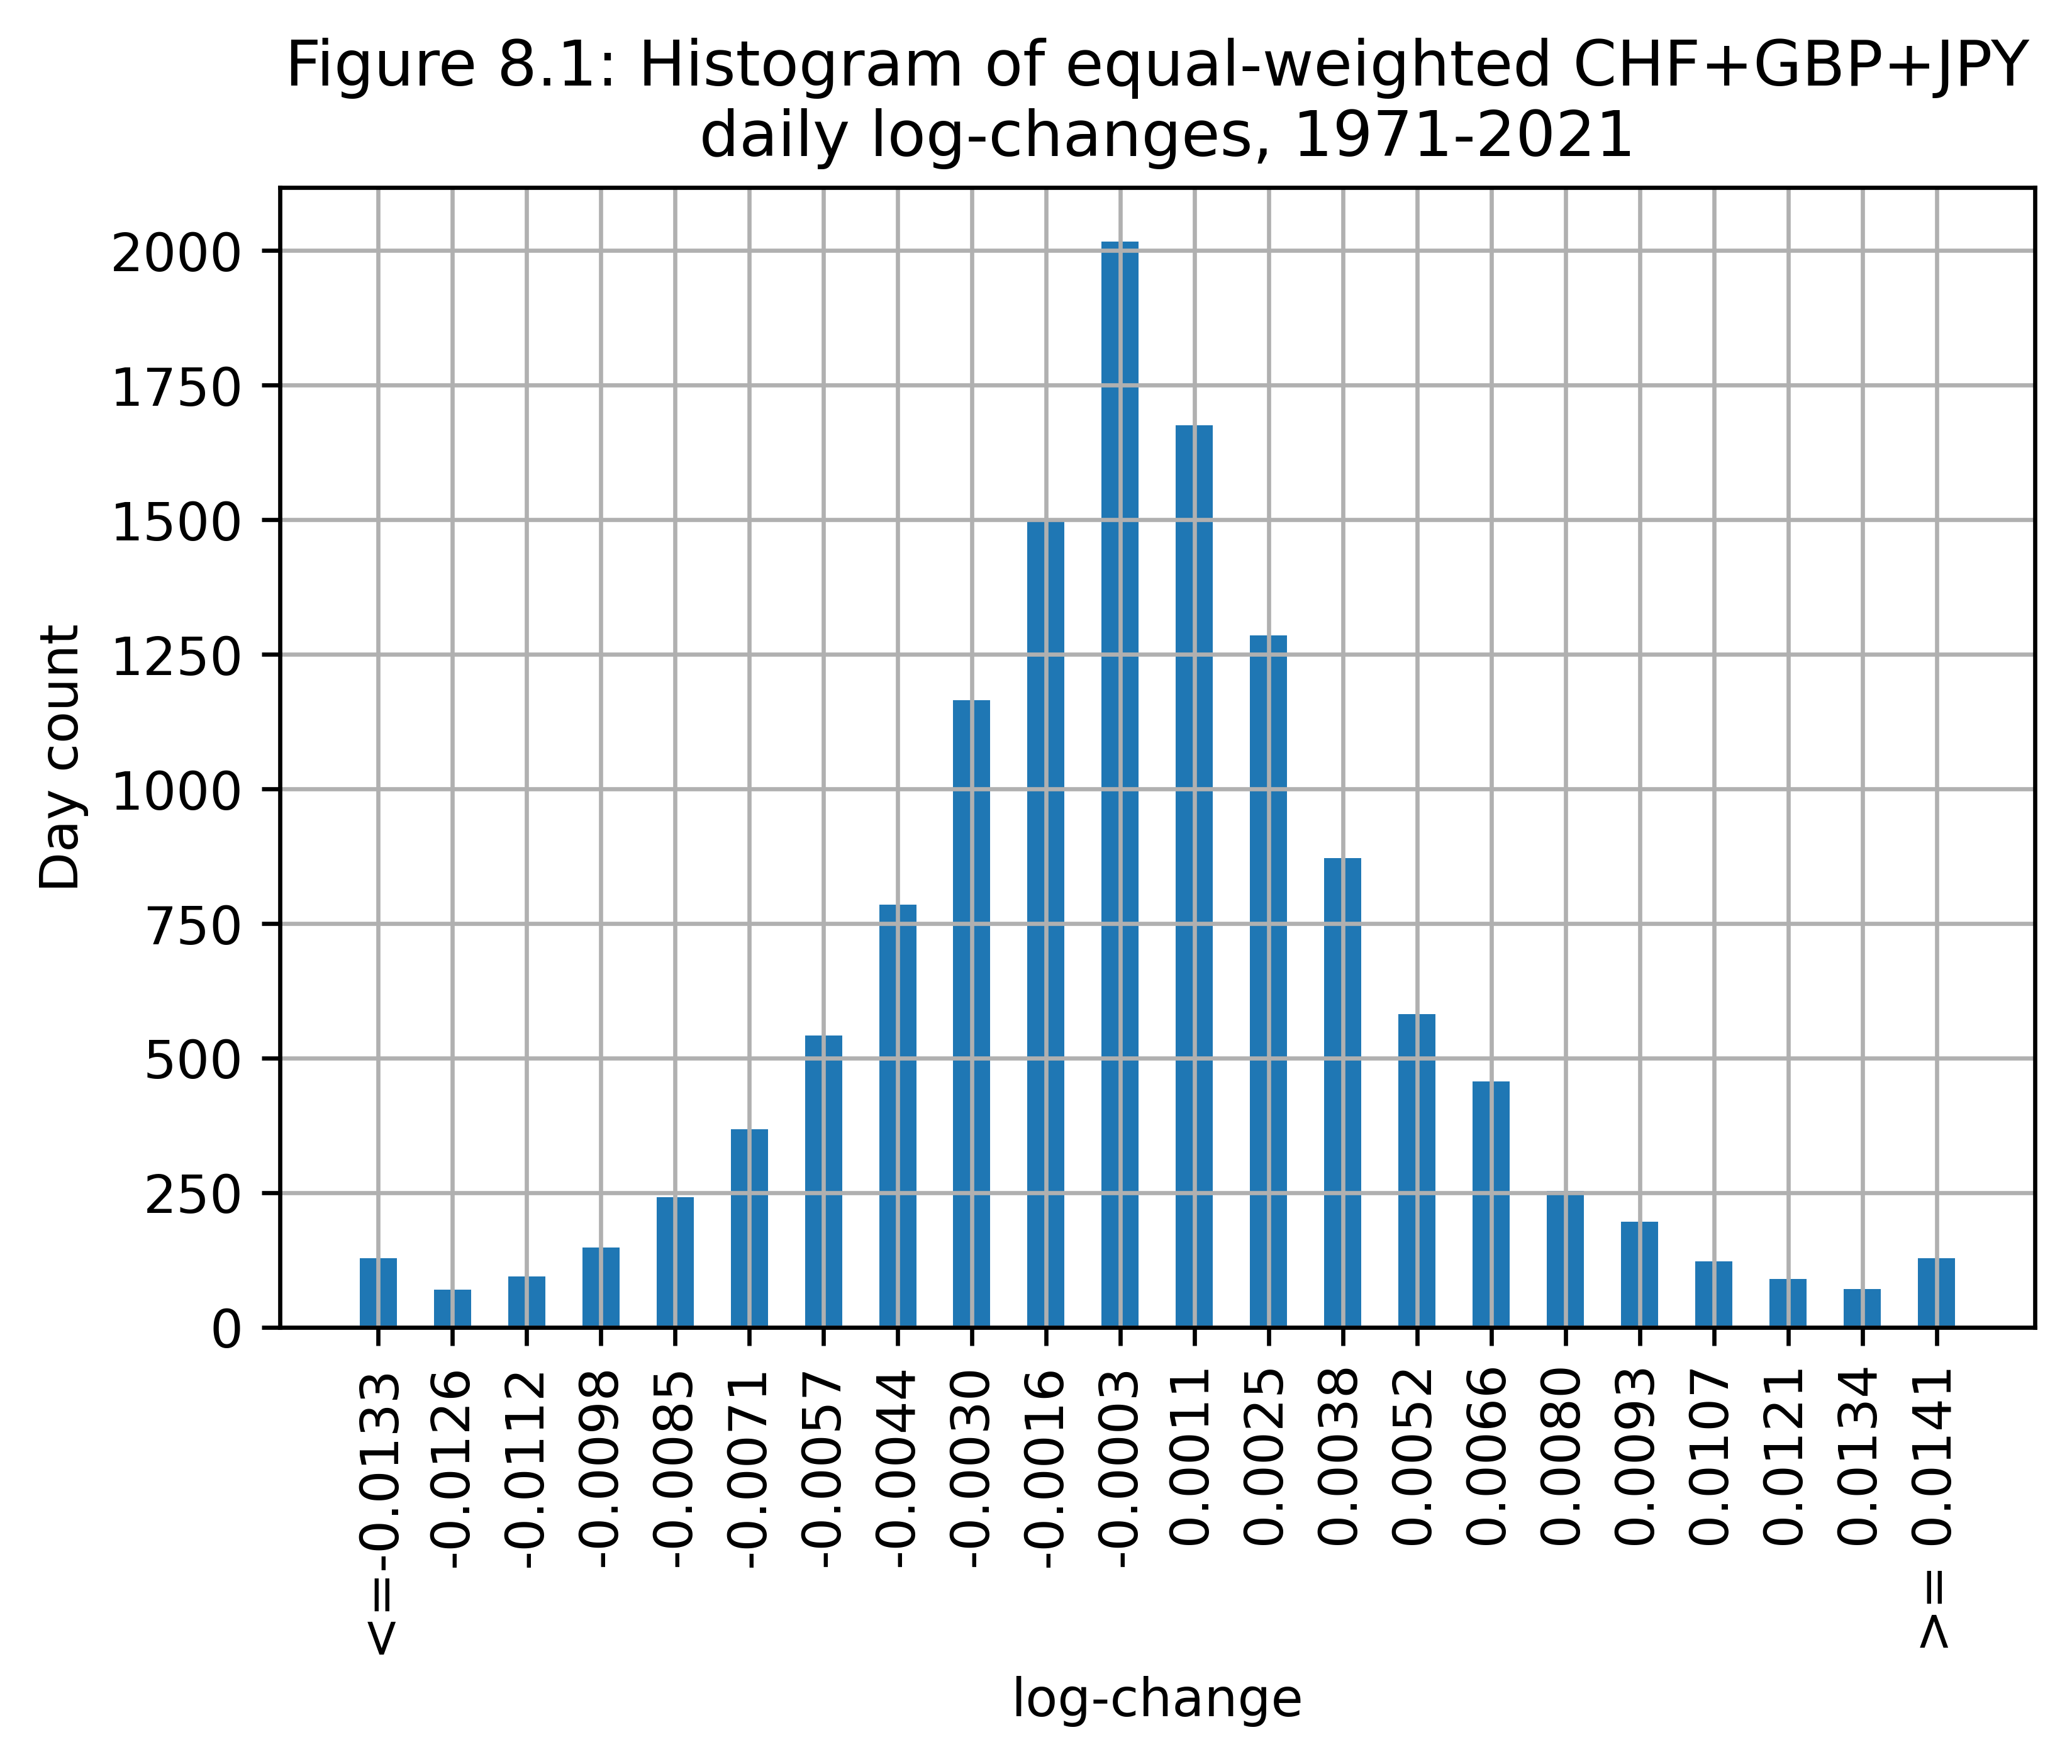

╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.041114  │
├────────────────────┼───────────────┤
│ Max                │     0.0516067 │
├────────────────────┼───────────────┤
│ Mean               │     7.5e-05   │
├────────────────────┼───────────────┤
│ Median             │     1.73e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0051541 │
├────────────────────┼───────────────┤
│ Skewness           │     0.241948  │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     4.79666   │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 12380.3       │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0255342 │
├────────────────────┼───────────────┤
│ 99% VaR            │   

Portfolio cumulative return: 1.2012038506475338
Portfolio annual return: 0.015905251399260356


In [3]:
#Code Segment 8.1
%matplotlib inline
import pandas as pd
import qrpm_funcs as qf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.stats as spst
plt.rcParams['figure.dpi']= 300
#Get 3 currencies until the end of
#previous year. Form sample covariance matrix
#and do simple efficient frontier calculations

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['DEXSZUS','DEXUSUK','DEXJPUS']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,enddate=lastday)
multipliers=[-1,1,-1]

lgdates,difflgs=qf.levels_to_log_returns(cdates,ratematrix,multipliers)

#Mean vector and covariance matrix are inputs to efficient frontier calculations
d=np.array(difflgs)
m=np.mean(d,axis=0)
c=np.cov(d.T)

#Show histogram of equal-weighted
#CHF-GBP-JPY log-changes
w=np.array([1/3]*3).T
#apply transform to get returns at portfolio level
portfolio=np.log(1+np.dot(np.exp(difflgs)-1,w))

#portfolio now contains the equal-weighted portfolio's
#log-returns. Create buckets - hist function doesn't
#seem to have "x or less" or "x or more" buckets
bucketnames=[]
bucketcounts=[]
#Bucket the end percentiles
low1=np.percentile(portfolio,1)
high1=np.percentile(portfolio,99)
bucketnames.append('<=%7.4f' % low1)
bucketcounts.append(sum(1 for x in portfolio if low1 >= x))
#Count 20 even buckets in between low and high
nbucket=20
bucketwidth=(high1-low1)/nbucket
for i in range(20):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(sum(1 for x in portfolio if (x>=attach and x<=detach)))

#last bucket
bucketnames.append('>=%7.4f' % high1)
bucketcounts.append(sum(1 for x in portfolio if x >= high1))

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.xlabel('log-change')
plt.ylabel('Day count')
plt.title('Figure 8.1: Histogram of equal-weighted CHF+GBP+JPY\n daily log-changes, '+ \
          lgdates[0][:4]+'-'+lastday[:4])
plt.show();
    
statnames,metrics,table=qf.StatsTable(np.exp(portfolio)-1)
headers=['Statistic','Value']
print(tabulate(table, headers, tablefmt='fancy_grid'))

port_log_ret=0
for t in range(len(d)):
    port_log_ret+=np.log(np.mean(np.exp(d[t,:])))
print('Portfolio cumulative return:',np.exp(port_log_ret)-1)
print('Portfolio annual return:',np.exp(port_log_ret/int(len(d)/252))-1)

## Code segment 8.2  
Figure 8.2 in Section 8.2

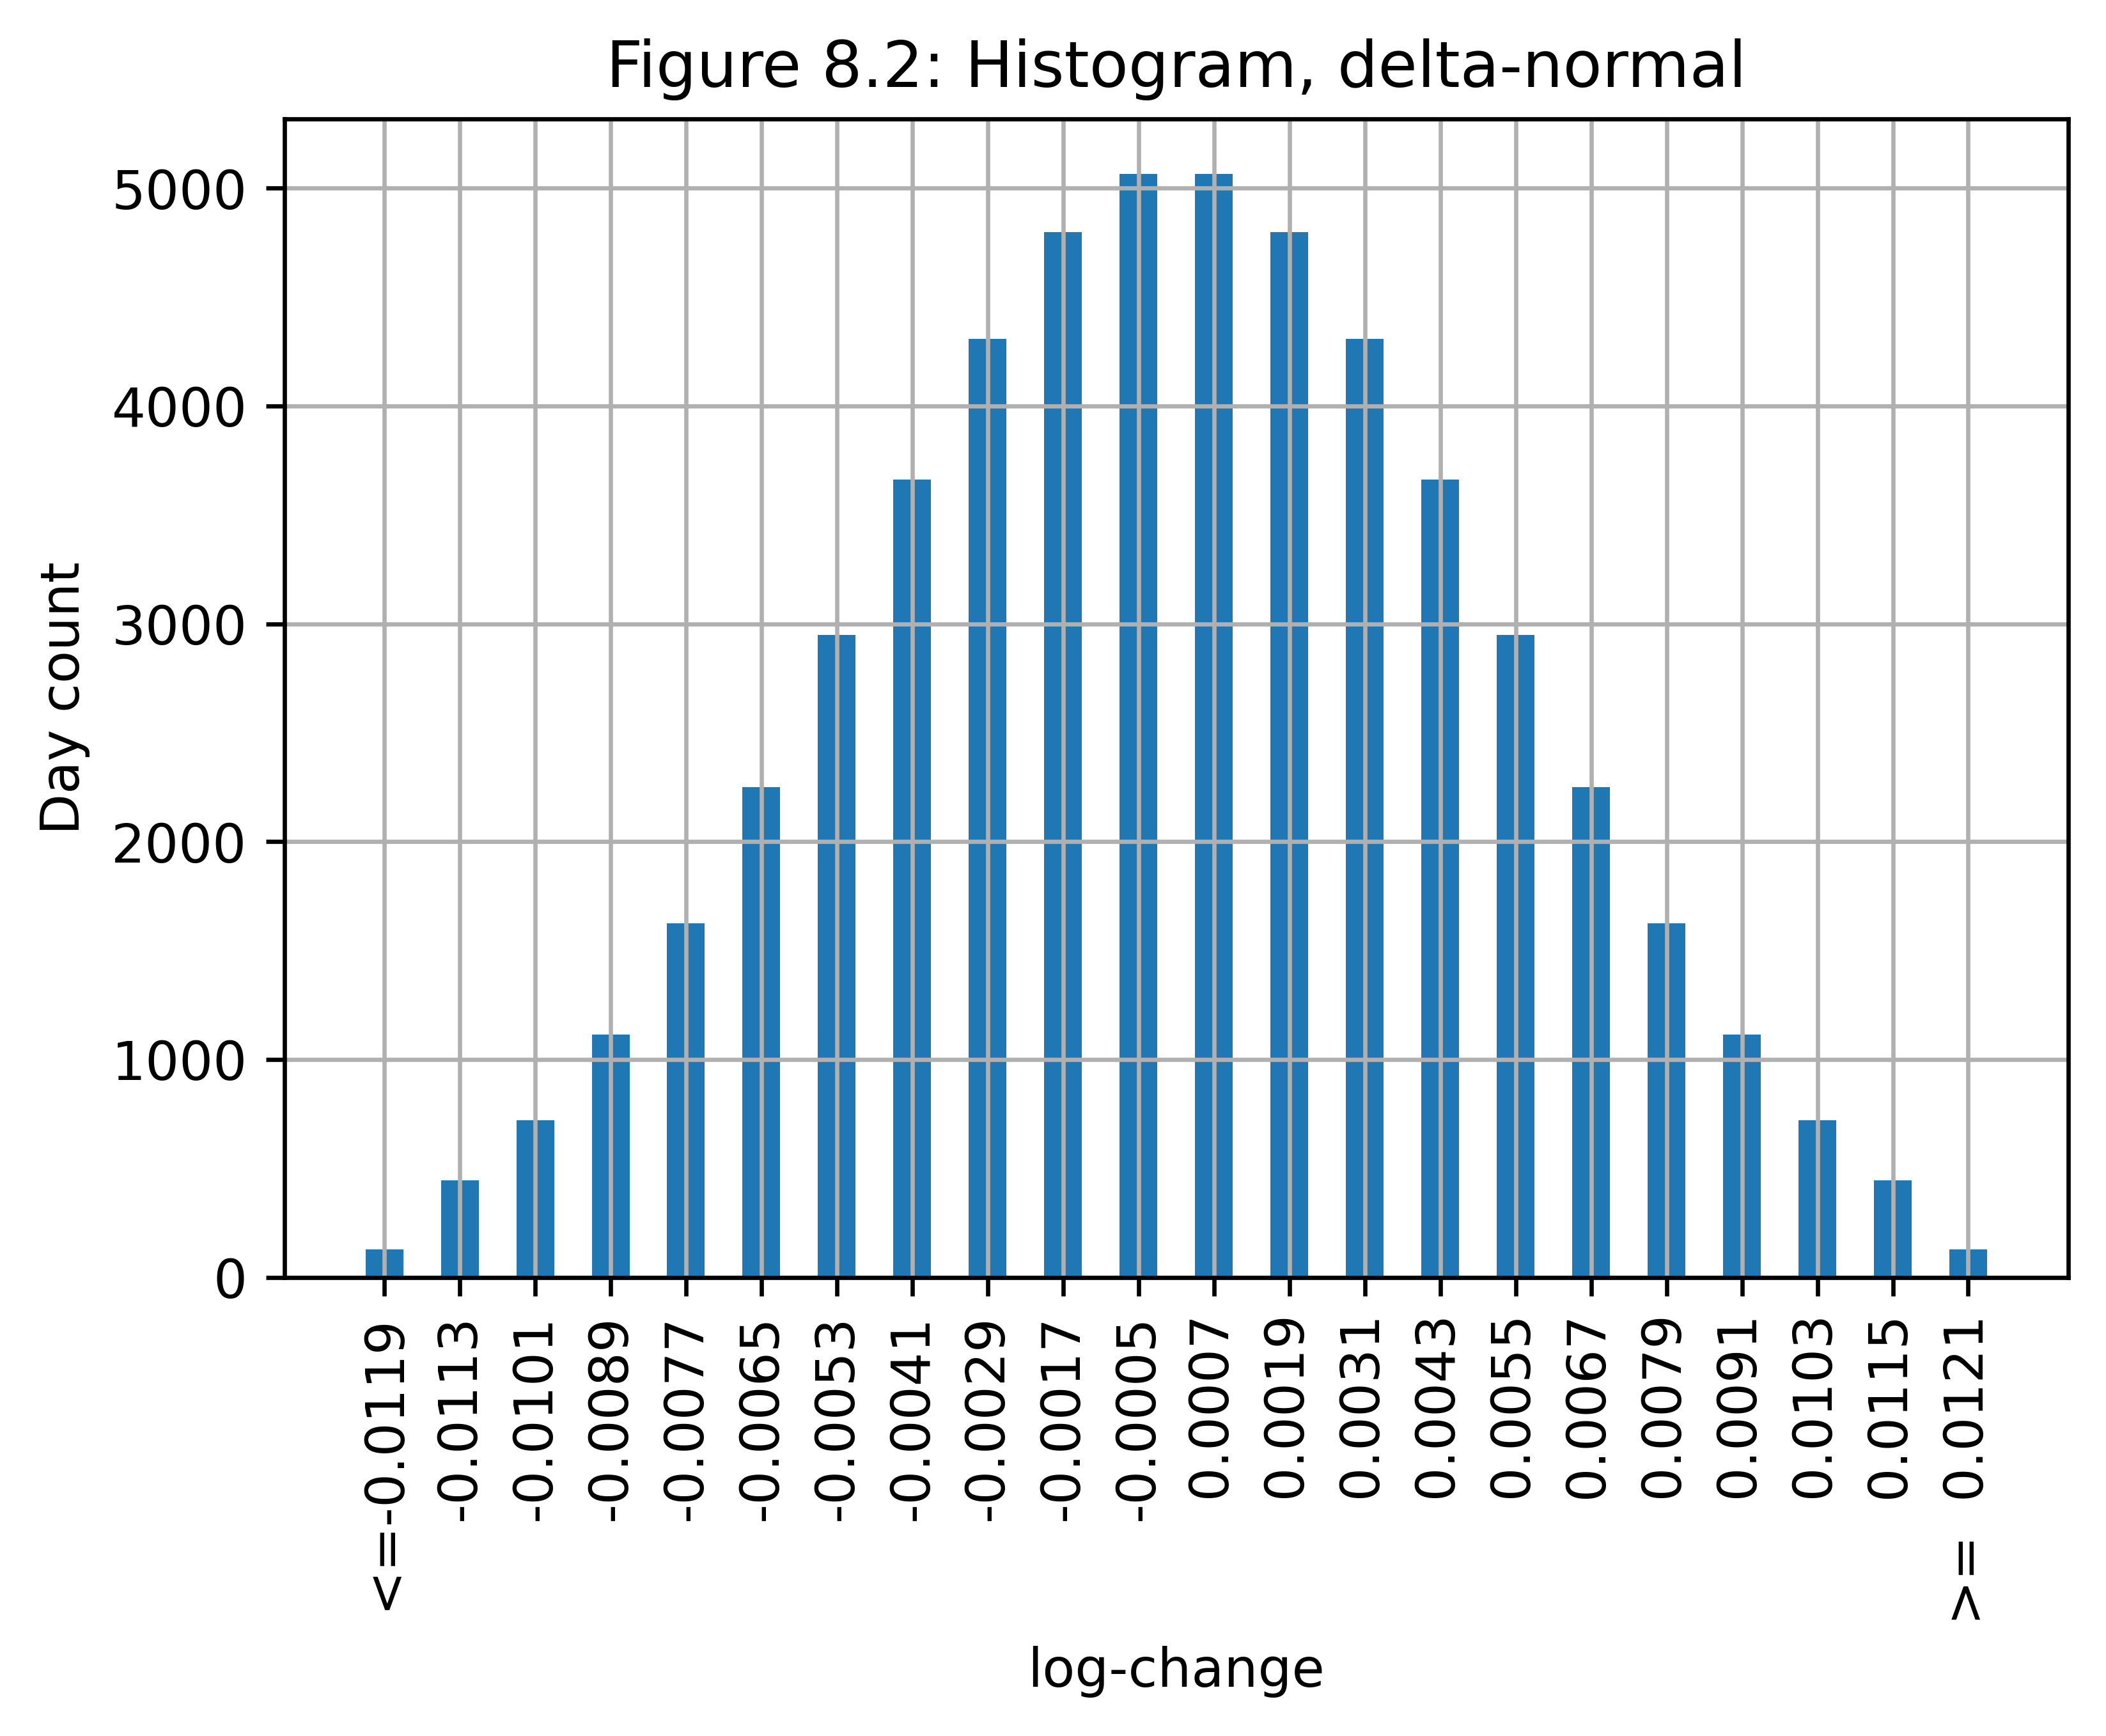

╒════════════════════╤════════════════╕
│ Statistic          │          Value │
╞════════════════════╪════════════════╡
│ Count              │ 12784          │
├────────────────────┼────────────────┤
│ Min                │    -0.0194116  │
├────────────────────┼────────────────┤
│ Max                │     0.0195616  │
├────────────────────┼────────────────┤
│ Mean               │     7.5e-05    │
├────────────────────┼────────────────┤
│ Median             │     7.5e-05    │
├────────────────────┼────────────────┤
│ Standard Deviation │     0.00515432 │
├────────────────────┼────────────────┤
│ Skewness           │     0          │
├────────────────────┼────────────────┤
│ Excess Kurtosis    │     0          │
├────────────────────┼────────────────┤
│ Jarque-Bera        │     0          │
├────────────────────┼────────────────┤
│ Chi-Squared p      │     1          │
├────────────────────┼────────────────┤
│ Serial Correlation │     0          │
├────────────────────┼────────────────┤


In [4]:
#Code Segment 8.2
#get count
count=metrics[0]
#Transform logs to return space
x_returns=np.array(np.exp(difflgs)-1)
m_returns=np.mean(x_returns,axis=0)
c_returns=np.cov(x_returns.T)
# compute mean and std deviation directly from m and c
port_mean=np.dot(m_returns,w)
port_std=np.sqrt(np.matmul(np.matmul(w,c_returns),w))

#Redo histogram with normal assumption

bucketcounts=[]
bucketnames=[]
#Bucket the end percentiles
low1=port_mean+port_std*spst.norm.ppf(.01)
high1=port_mean+port_std*spst.norm.ppf(.99)
bucketwidth=(high1-low1)/nbucket
bucketcounts.append(spst.norm.cdf((low1-port_mean)/port_std)*count)
bucketnames.append('<=%7.4f' % low1)
for i in range(nbucket):
    attach=low1+i*bucketwidth
    detach=attach+bucketwidth
    mid=(attach+detach)/2
    bucketnames.append('%7.4f' % mid)
    bucketcounts.append(spst.norm.pdf((mid-port_mean)/port_std)*count)

#last bucket
bucketcounts.append((1-spst.norm.cdf((high1-port_mean)/port_std))*count)
bucketnames.append('>=%8.4f' % high1)

width=.5
plt.bar(range(nbucket+2),bucketcounts,width)
plt.xticks(range(nbucket+2),bucketnames,rotation='vertical')
plt.grid()
plt.xlabel('log-change')
plt.ylabel('Day count')
plt.title('Figure 8.2: Histogram, delta-normal')
plt.show();

#Delta-normal calculations - redo the stats table
table_norm=np.copy(table)
table_norm[1][1]=str(port_mean+spst.norm.ppf(1/(count+1))*port_std)    #min
table_norm[2][1]=str(port_mean+spst.norm.ppf(count/(count+1))*port_std)    #max
table_norm[3][1]='%7.7f' % port_mean    #mean - should be the same
table_norm[4][1]=table_norm[3][1]    #median - make it equal the mean because normal
table_norm[5][1]=str(port_std)    #standard deviation - use sqrt(w'Cw)
table_norm[6][1]="0"    #skewness - zero because normal
table_norm[7][1]="0"    #skewness - zero because normal
table_norm[8][1]="0"    #Jarque-Bera - zero because normal
table_norm[9][1]="1"    #Chi-squared - one because normal
table_norm[10][1]="0"    #Serial correlation - zero by assumption
p=.99
norm_VaR=-(port_mean+spst.norm.ppf(1-p)*port_std)
table_norm[11][1]=str(norm_VaR)    #99% VaR - from formula
norm_cVaR=port_std*np.exp(-.5*(norm_VaR/port_std)**2)
norm_cVaR/=(1-p)*np.sqrt(2*np.pi)
norm_cVaR=-port_mean+norm_cVaR
table_norm[12][1]=str(norm_cVaR)    #99% cVar - from formula
print(tabulate(table_norm, headers, tablefmt='fancy_grid'))

## Code segment 8.3  
Gradient computation in Section 8.2

In [5]:
#Code Segment 8.3
#Compute gradient
port_gradient=np.matmul(c_returns,w)/port_std
print('Gradient (bps/day):',port_gradient)
print('Contributions to Std Dev:',port_gradient*w)

Gradient (bps/day): [0.00616951 0.00457384 0.00471963]
Contributions to Std Dev: [0.0020565  0.00152461 0.00157321]


## Code segment 8.4  
Figure 8.3 in Section 8.2.1

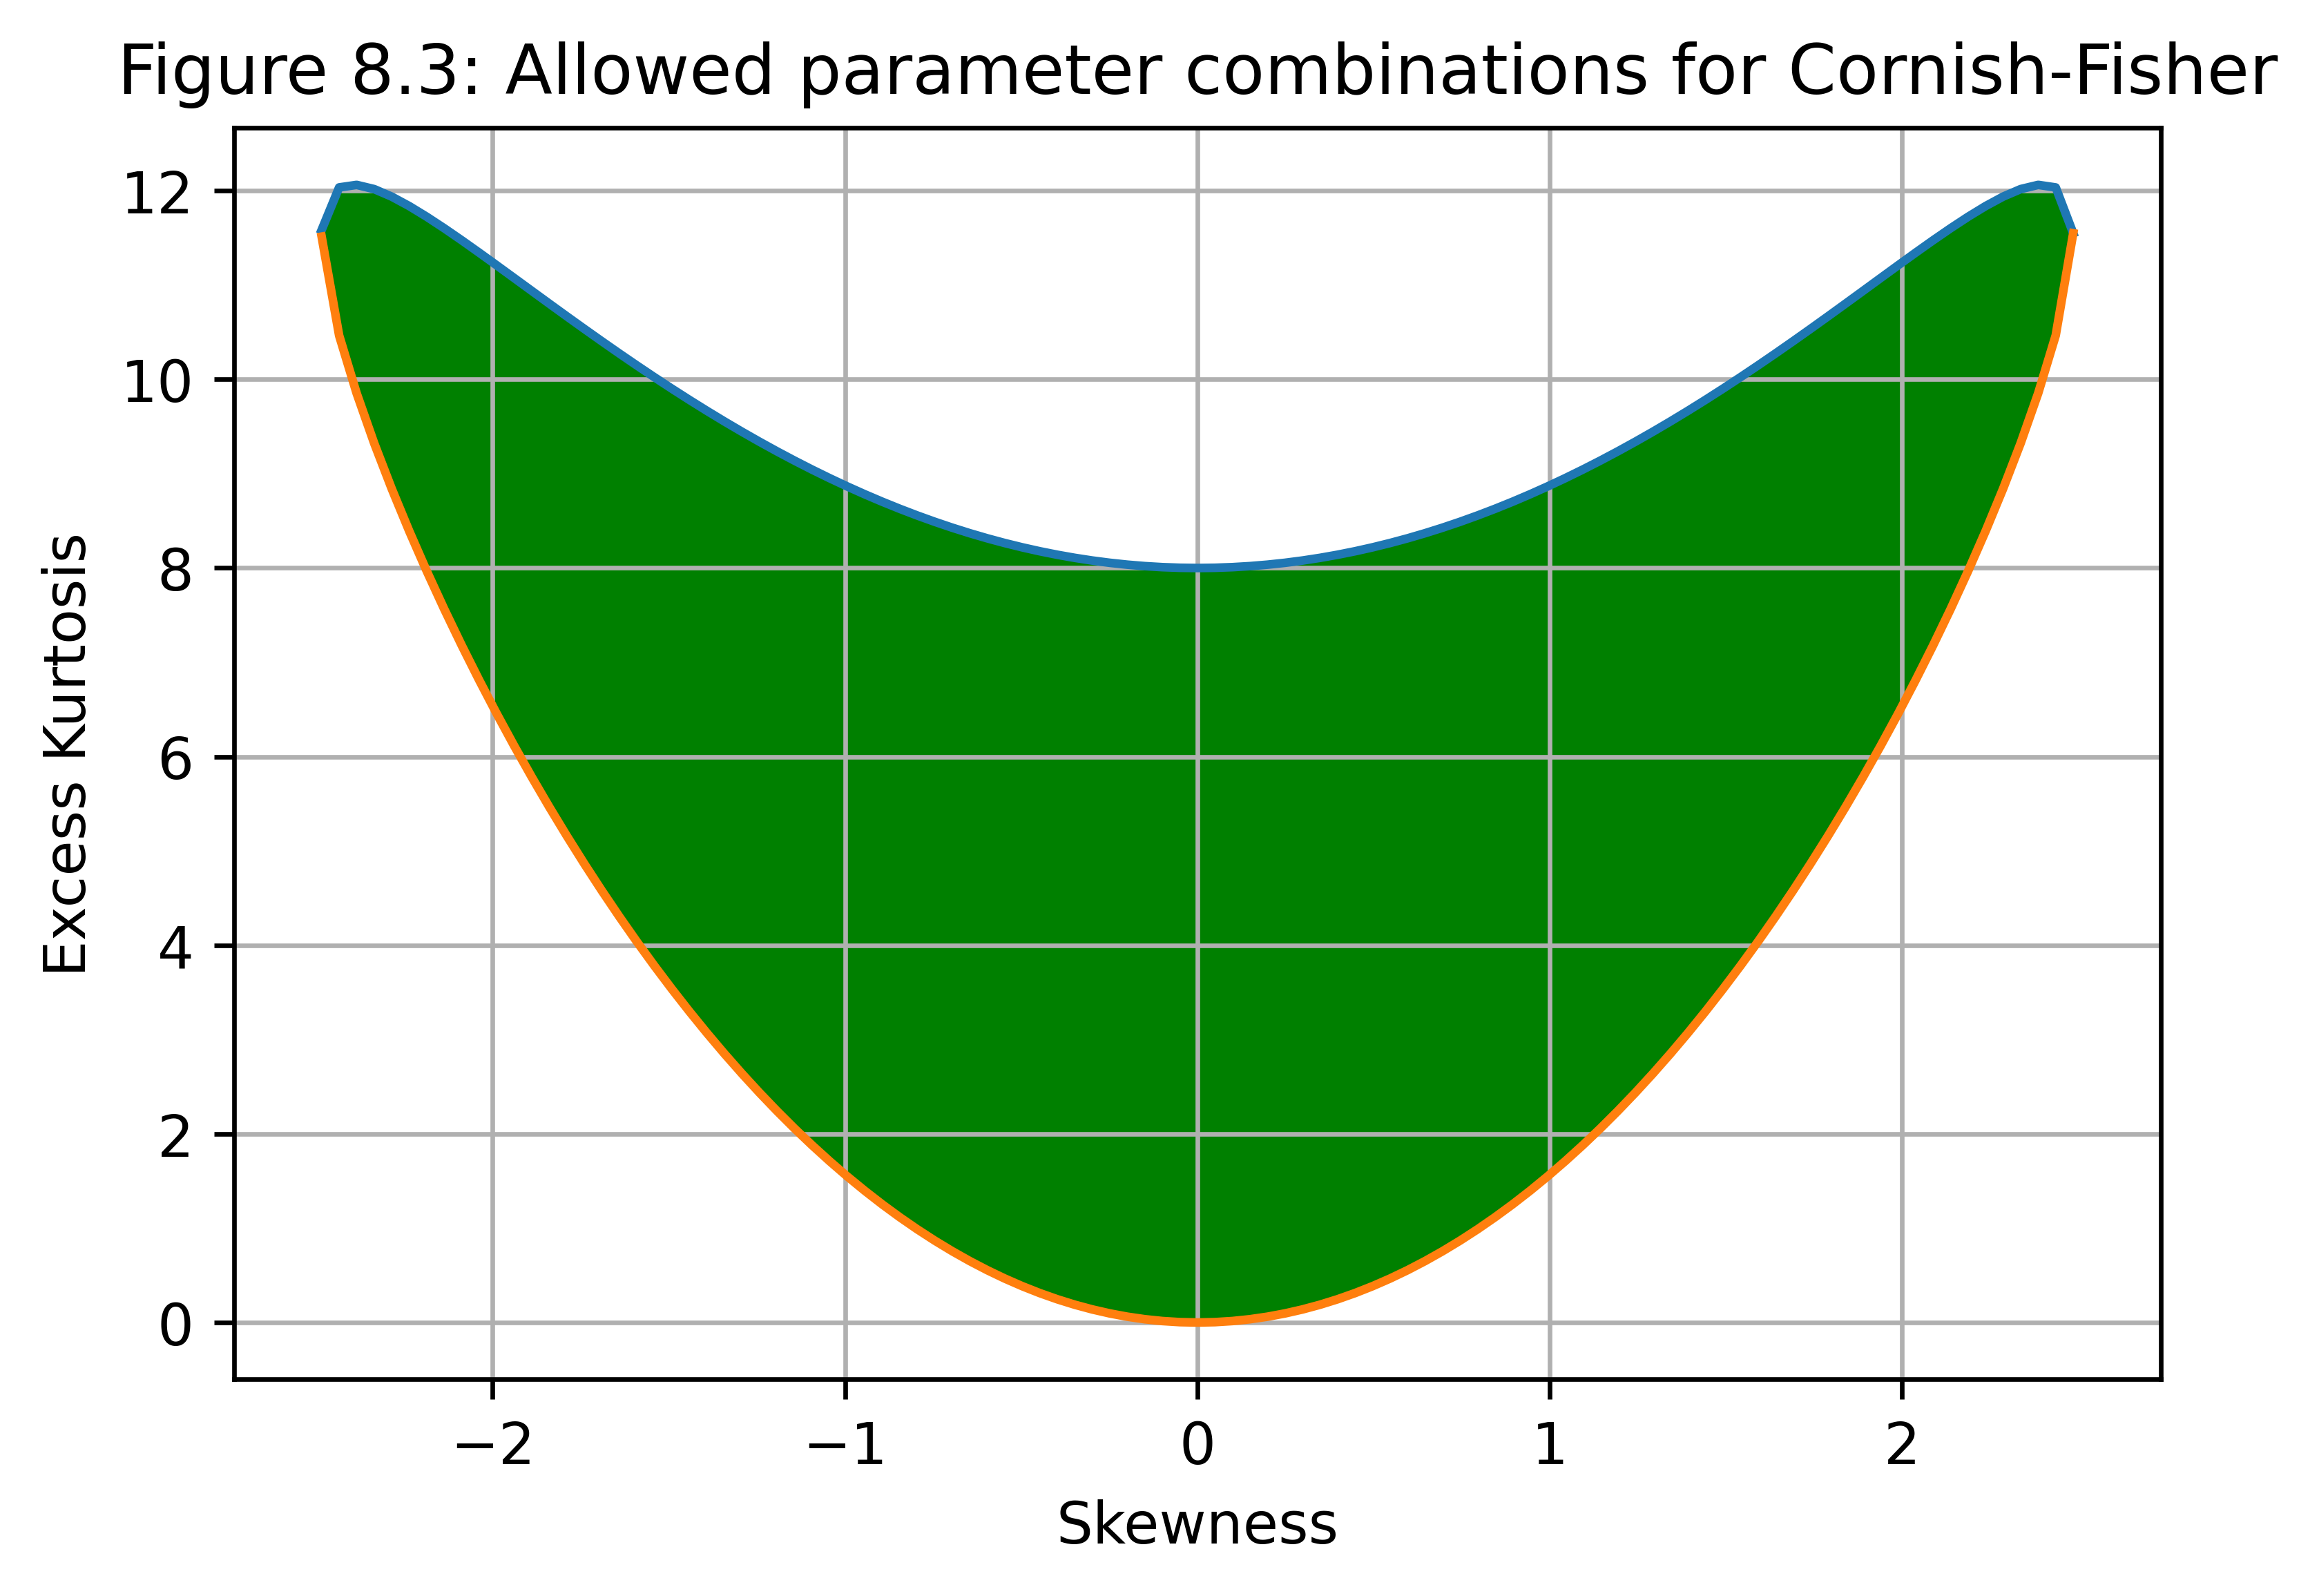

In [6]:
#Code Segment 8.4
#Draw Cornish-Fisher admissability graph
stepsize=12*(np.sqrt(2)-1)/100
x=np.arange(-50*stepsize+.0001,
            50*stepsize,stepsize)
y1=[4*(1+11*(x/6)**2+np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
y2=[4*(1+11*(x/6)**2-np.sqrt((x/6)**4-6*(x/6)**2+1))][0]
x=np.append(x,50*stepsize)
y1=np.append(y1,4*(1+11*(x[100]/6)**2))
y2=np.append(y2,4*(1+11*(x[100]/6)**2))
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2,facecolor='green')
plt.xlabel('Skewness')
plt.ylabel('Excess Kurtosis')
plt.title('Figure 8.3: Allowed parameter combinations for Cornish-Fisher')
plt.grid()
plt.show();

## Code segment 8.5  
Cornish-Fisher calculations in Section 8.2.1

In [7]:
#Code Segment 8.5
#Compute new z-score using 8.4
z=spst.norm.ppf(p)
znew=z-(1/6)*(z**2-1)*spst.skew(portfolio)
znew+=(z/24)*(z**2-3)*spst.kurtosis(portfolio)
znew-=(z/36)*(2*z**2-5)*spst.skew(portfolio)**2
print_str='Normal %2.f pct' % np.multiply(p,100.)
print_str+=" z: %8.5f" % z
print(print_str)
print('Cornish-Fisher: %8.5f' % znew)
#Compare with historical
hs_99VaR=-np.percentile(portfolio,1)
zhist=(hs_99VaR+port_mean)/port_std
print('Historical: %8.5f' % zhist)

#Show comparisons of VaRs
print_str='\nNormal %2.f pct' % np.multiply(p,100.)
print_str+=" VaR: %8.5f" % norm_VaR
print(print_str)
cf_99VaR=-port_mean+znew*port_std
print('Cornish-Fisher VaR: %8.5f' % cf_99VaR)
print('Historical VaR: %8.5f' % hs_99VaR)

Normal 99 pct z:  2.32635
Cornish-Fisher:  3.27137
Historical:  2.58673

Normal 99 pct VaR:  0.01192
Cornish-Fisher VaR:  0.01679
Historical VaR:  0.01326


## Code segment 8.6  
Cholesky decomposition in Section 8.3

In [8]:
#Code Segment 8.6
#Show the Cholesky decomposition
#of the CHF-GPB-JPY covariance matrix
chol=np.linalg.cholesky(c)
print('(8.8) Cholesky decomposition of 3-currency sample'+ \
      ' covariance matrix:\n',chol*100)

(8.8) Cholesky decomposition of 3-currency sample covariance matrix:
 [[0.70595279 0.         0.        ]
 [0.34035761 0.4882504  0.        ]
 [0.30198568 0.02130788 0.55610753]]


## Code segment 8.7  
Monte Carlo statistics in Section 8.3

In [9]:
#Code Segment 8.7
#Generate random draws; use fixed seed to be replicable
from numpy.random import default_rng
rng = default_rng(12345678)

s_trial=rng.normal(0,1,size=[count,3])
logr_trial=np.matmul(chol,s_trial.T).T+m

#logr_trial has Monte Carlo log-returns; transform to returns
r_trial=np.exp(logr_trial)-1

#Get trial portfolio returns
r_ptrial=np.matmul(r_trial,w)
print("Monte Carlo with simple normal draws")
statnames,mettrial,tabtrial=qf.StatsTable(r_ptrial)
print(tabulate(tabtrial, headers, tablefmt='fancy_grid'))

Monte Carlo with simple normal draws
╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.0204272 │
├────────────────────┼───────────────┤
│ Max                │     0.0185333 │
├────────────────────┼───────────────┤
│ Mean               │    -4.3e-06   │
├────────────────────┼───────────────┤
│ Median             │     1.08e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0051776 │
├────────────────────┼───────────────┤
│ Skewness           │     0.0277483 │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │    -0.0306785 │
├────────────────────┼───────────────┤
│ Jarque-Bera        │     2.14188   │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0.342687  │
├────────────────────┼───────────────┤
│ Serial Correlation │     0.0068568 │
├────────────────────┼─────

## Code segment 8.8  
Monte Carlo statistics with mixtures of normals in Section 8.3

In [10]:
#Code Segment 8.8
#Three-currency Monte Carlo with separate mixtures of normals
import random

def mixparams(d_in):
    #Find mixture-of-2-normals parameters w1, r, and sigma2 (7.20)
    sigma_mix=np.std(d_in)
    k_mix=spst.kurtosis(d_in)  #default is Fisher (normal=0)
    k=k_mix/3.+1
    w_1=min(.05,.9/k)   #Avoid negative denominator in r
    r=(k*(1-w_1)*w_1+np.sqrt(w_1*(1.-w_1)*(k-1.)))/(w_1*(1-k*w_1))
    sigma_2=sigma_mix/np.sqrt(w_1*r+1.-w_1)
    return(w_1,r,sigma_2)
#Done with mixparams

rng = default_rng(33550336)   #5th perfect number
s_mix=[]
#Generate mix for each asset separately
for asset in range(len(d.T)):
    w1,r,s2=mixparams(d[:,asset])
    count_1=int(count*w1)
    count_2=count-count_1
    s_1=rng.normal(0,np.sqrt(r)*s2,size=count_1)
    s_2=rng.normal(0,s2,size=count_2)
    s_mix.append(random.sample(list(np.append(s_1,s_2)),k=count))

#Cholesky factor of correlation matrix
corr_chol = np.linalg.inv(np.diag(np.sqrt(np.diagonal(c)))) @ chol
    
#introduce covariance structure and translate
logr_mix=(corr_chol @ s_mix).T+m

#logr_mix has Monte Carlo log-returns; transform to returns
ret_mix=np.exp(logr_mix)-1

#Get trial portfolio returns
ret_pmix=np.matmul(ret_mix,w)
print("Monte Carlo with leptokurtic mixtures of normals")
statnames,mettrial,tabtrial=qf.StatsTable(ret_pmix)
print(tabulate(tabtrial, headers, tablefmt='fancy_grid'))

Monte Carlo with leptokurtic mixtures of normals
╒════════════════════╤═══════════════╕
│ Statistic          │         Value │
╞════════════════════╪═══════════════╡
│ Count              │ 12784         │
├────────────────────┼───────────────┤
│ Min                │    -0.0489417 │
├────────────────────┼───────────────┤
│ Max                │     0.0450168 │
├────────────────────┼───────────────┤
│ Mean               │     7.13e-05  │
├────────────────────┼───────────────┤
│ Median             │     8.78e-05  │
├────────────────────┼───────────────┤
│ Standard Deviation │     0.0054715 │
├────────────────────┼───────────────┤
│ Skewness           │    -0.17533   │
├────────────────────┼───────────────┤
│ Excess Kurtosis    │     8.69471   │
├────────────────────┼───────────────┤
│ Jarque-Bera        │ 40334         │
├────────────────────┼───────────────┤
│ Chi-Squared p      │     0         │
├────────────────────┼───────────────┤
│ Serial Correlation │    -0.0011667 │
├──────────────

## Code segment 8.9  
MCMC Metropolis-Hastings in Section 8.4

In [11]:
#Code Segment 8.9
#MCMC on 3x3 state transition matrix
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

rng = default_rng(138064852)  #Boltzmann

def tent(i,j):
    #Tent proposal distribution
    if j==i:
        return(2./3.)
    else:
        return(1./6.)

def transition(i,j):
    #Transition probability 
    T=[[.6,.3,.1],[.3,.5,.2],[.1,.2,.7]]
    if i<0 or i>2 or j<0 or j>2 or (not isinstance(i,int)) or (not isinstance(j,int)):
        return(0)
    return(T[i][j])

def picktent(x):
    #Pick a random state given previous state is x
    movers=[0,0,0,0,1,2]
    choose=rng.integers(0,6)
    pick=int(x+movers[choose])
    return(pick % 3)

n=1000  #Arbitrary
burnin=int(.2*n)

#Step 1
x=[0 for i in range(n)]
x[0]=1   #Start in middle state

for t in range(n-1):
    #Step 2
    s_t=picktent(x[t])
    #Step 3
    trans_ratio=transition(s_t,x[t])/transition(x[t],s_t)
    prop_ratio=tent(x[t],s_t)/tent(s_t,x[t])
    accept_ratio=trans_ratio*prop_ratio
    #Step 4
    u_t=rng.uniform()
    if accept_ratio >= u_t:
        x[t+1]=s_t
    else:
        x[t+1]=x[t]
        
for state in range(3):
    this_pct=sum([1 for samp in x[burnin:] if samp==state])/(n-burnin)
    print_str="    State: %d" % state
    print_str+=" MCMC: %5.3f" % this_pct
    print_str+=" Theoretical: %5.3f" % float(1./3.)
    print(print_str)


    State: 0 MCMC: 0.315 Theoretical: 0.333
    State: 1 MCMC: 0.321 Theoretical: 0.333
    State: 2 MCMC: 0.364 Theoretical: 0.333


## Code segment 8.10  
Figures 8.4.1 to 8.4.3 in Section 8.4

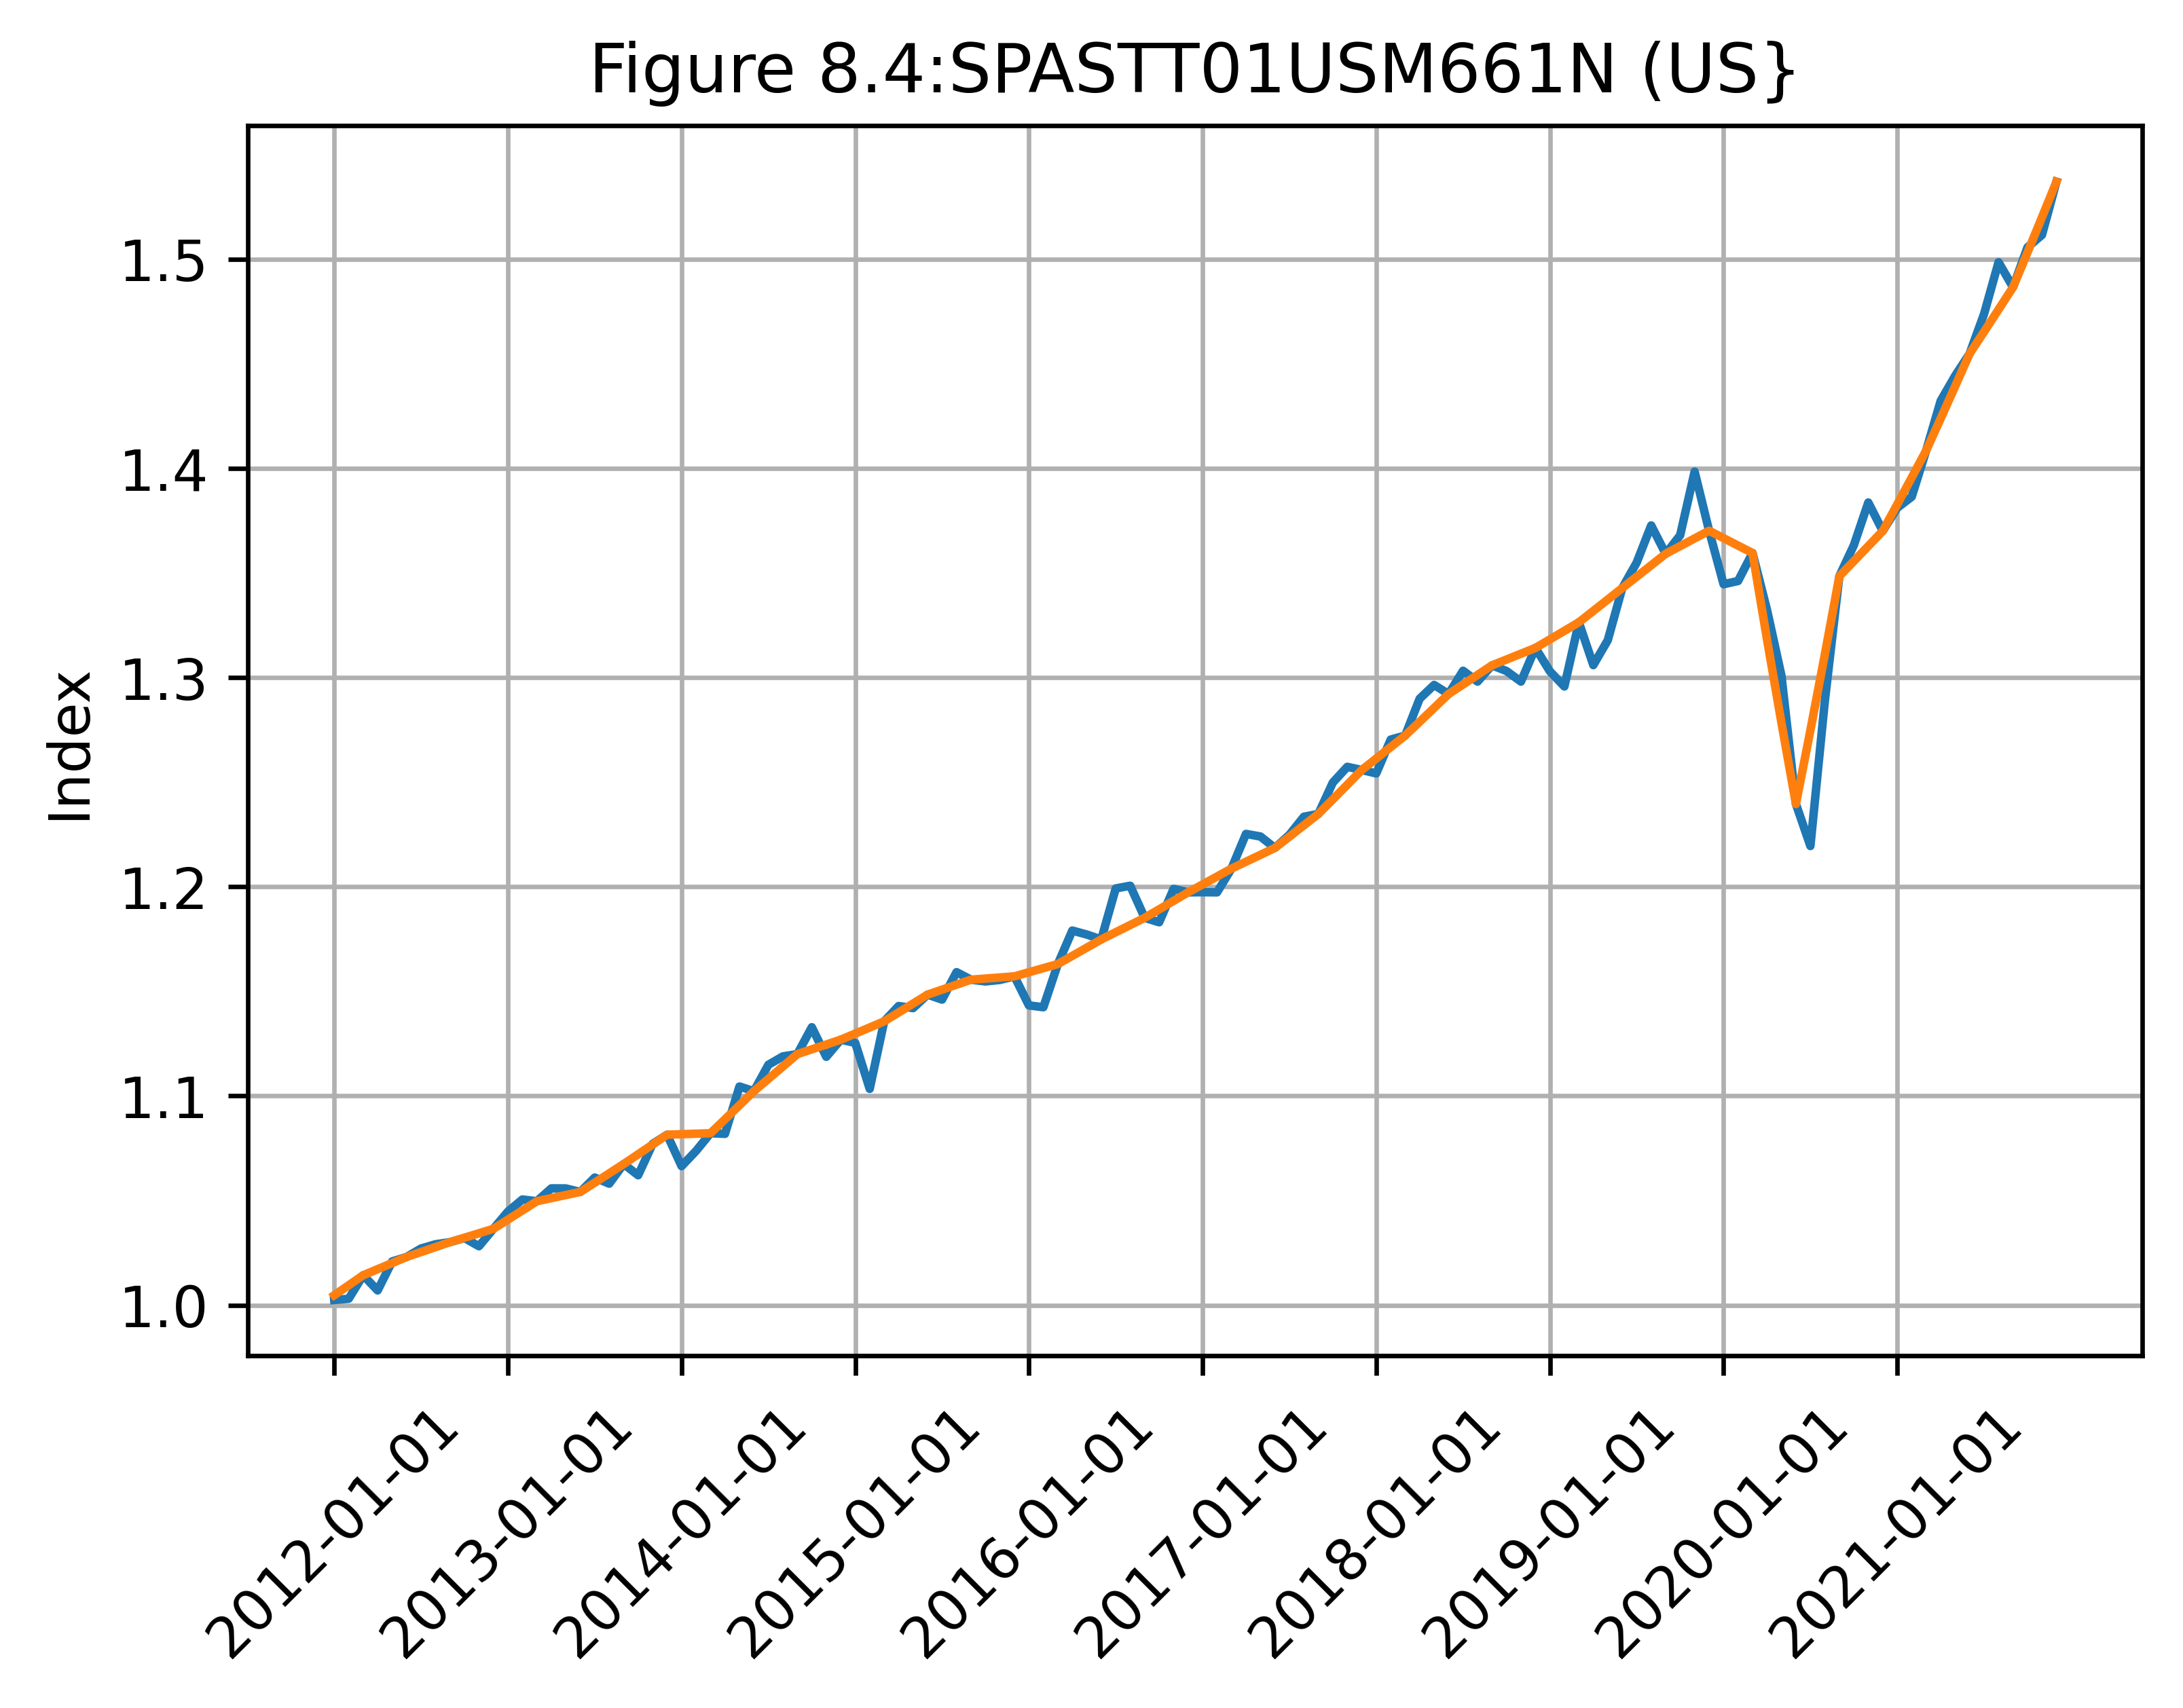

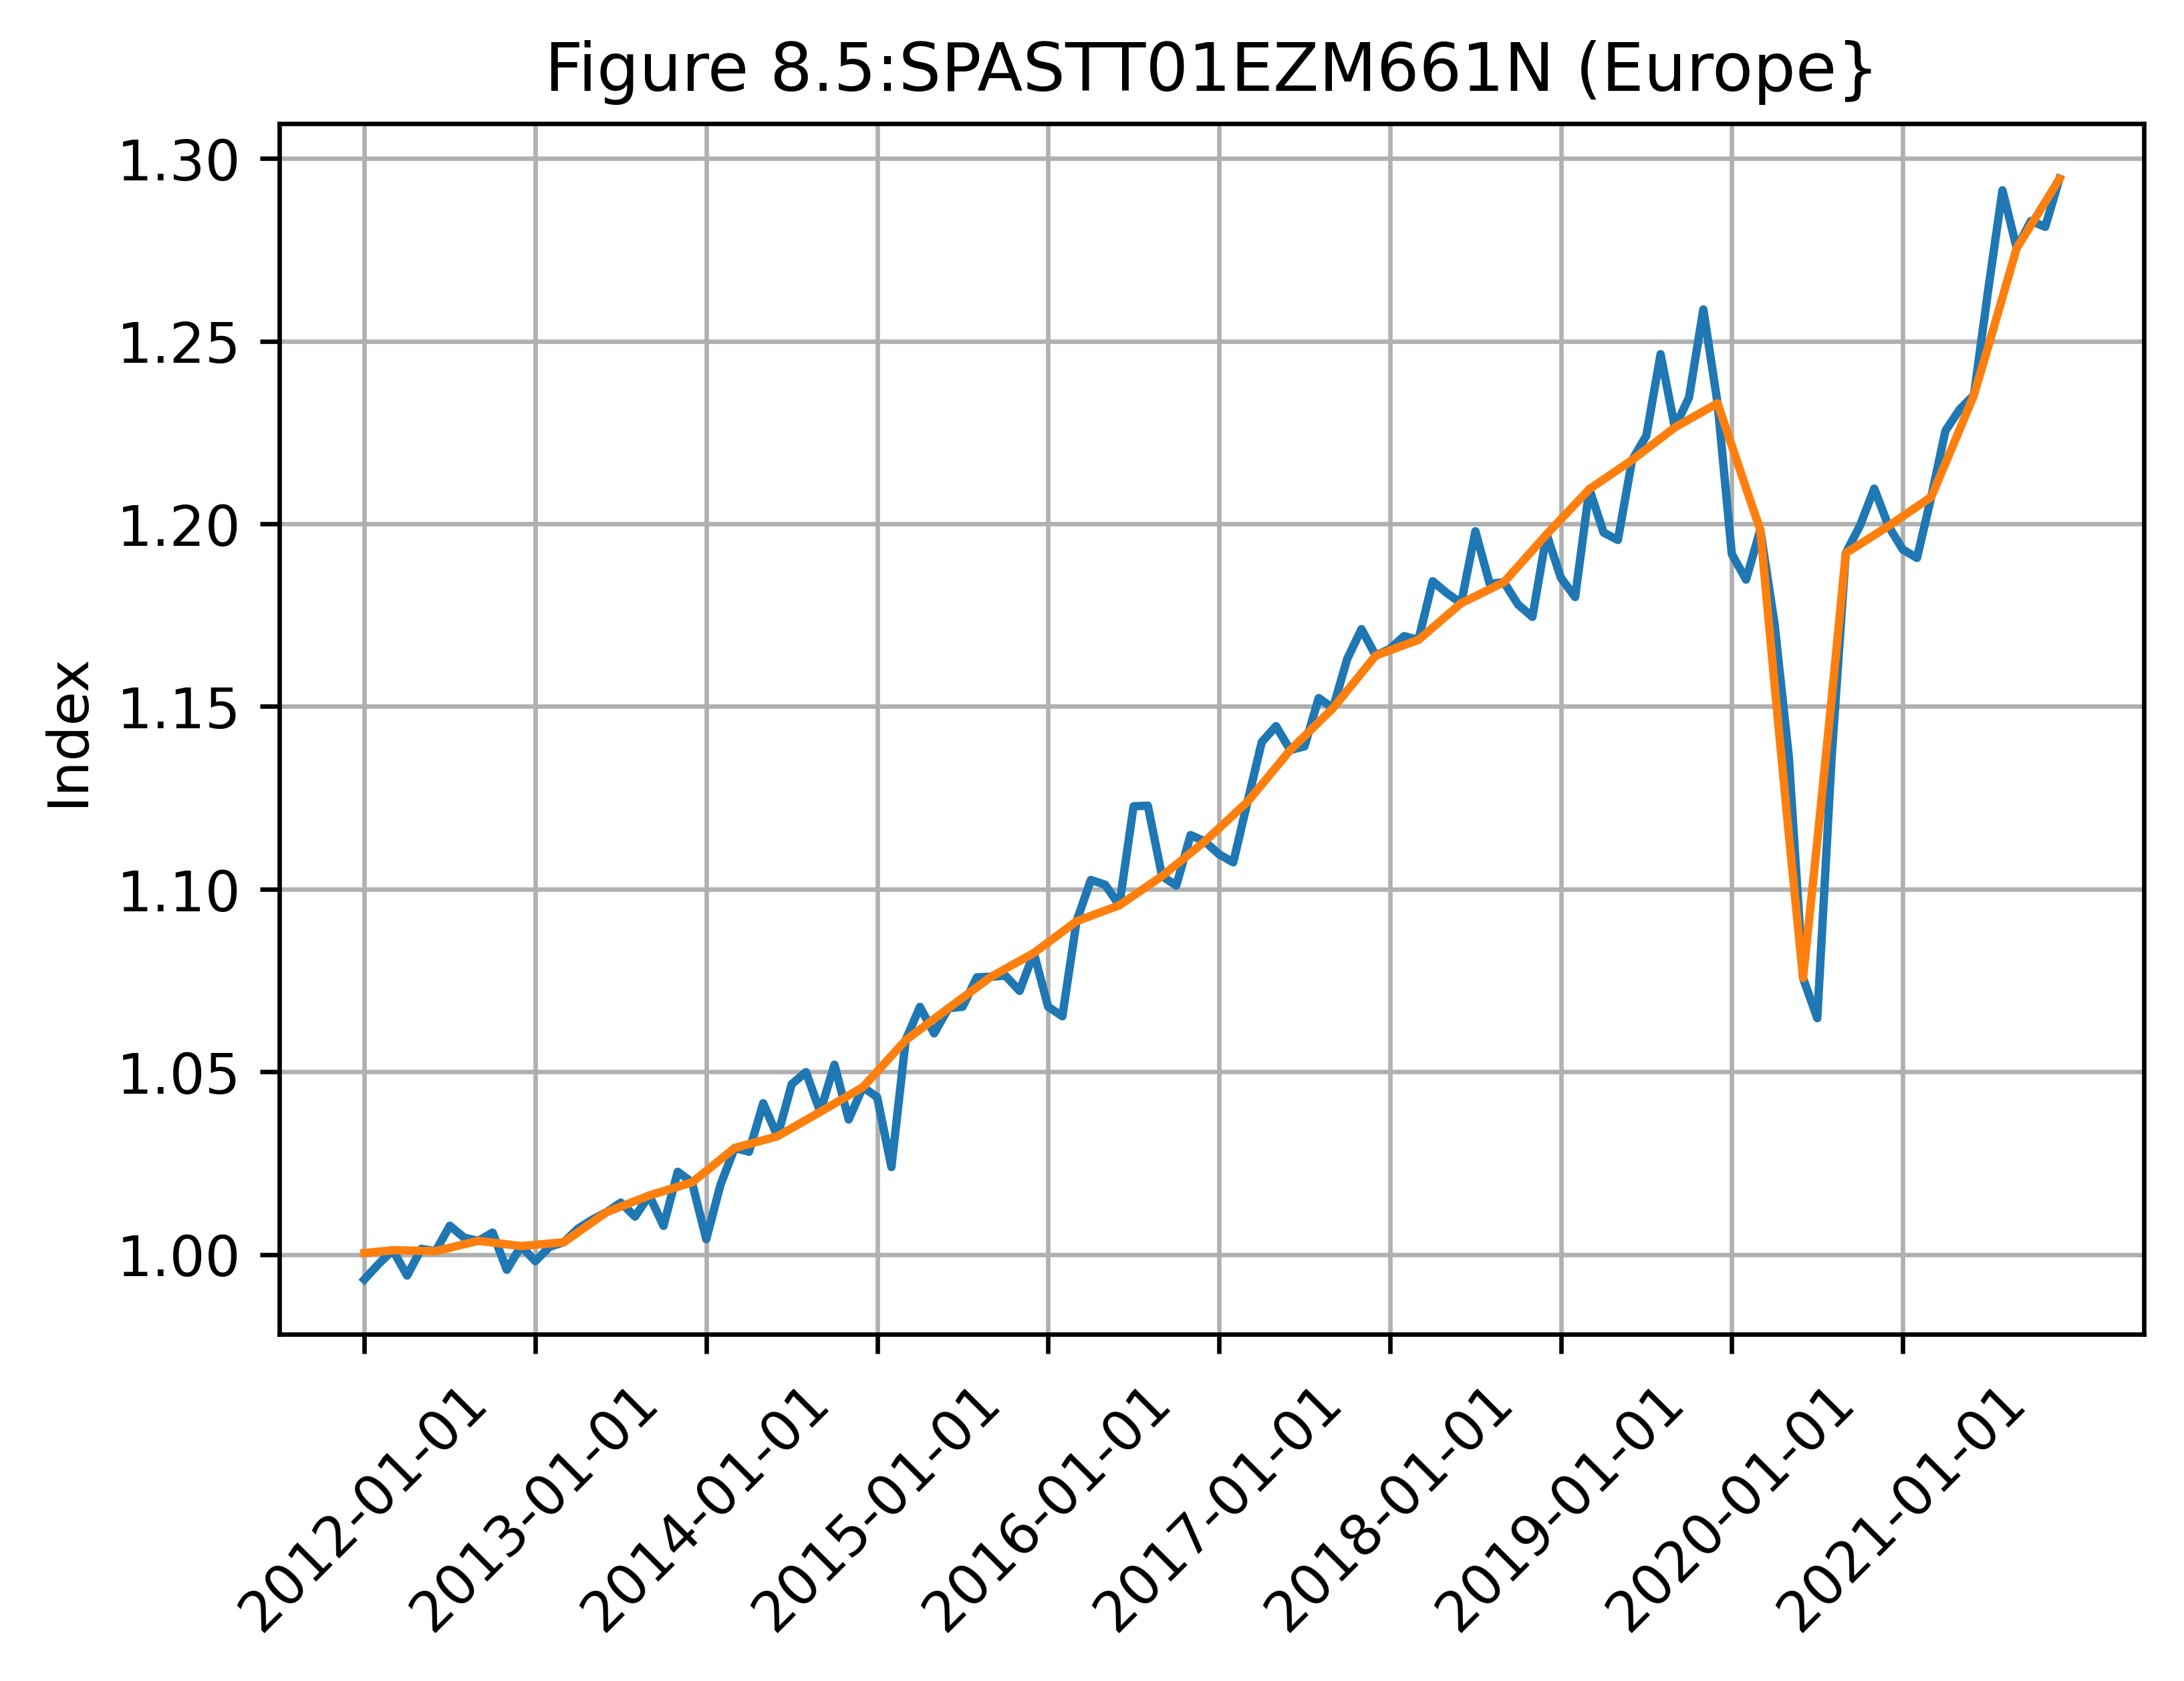

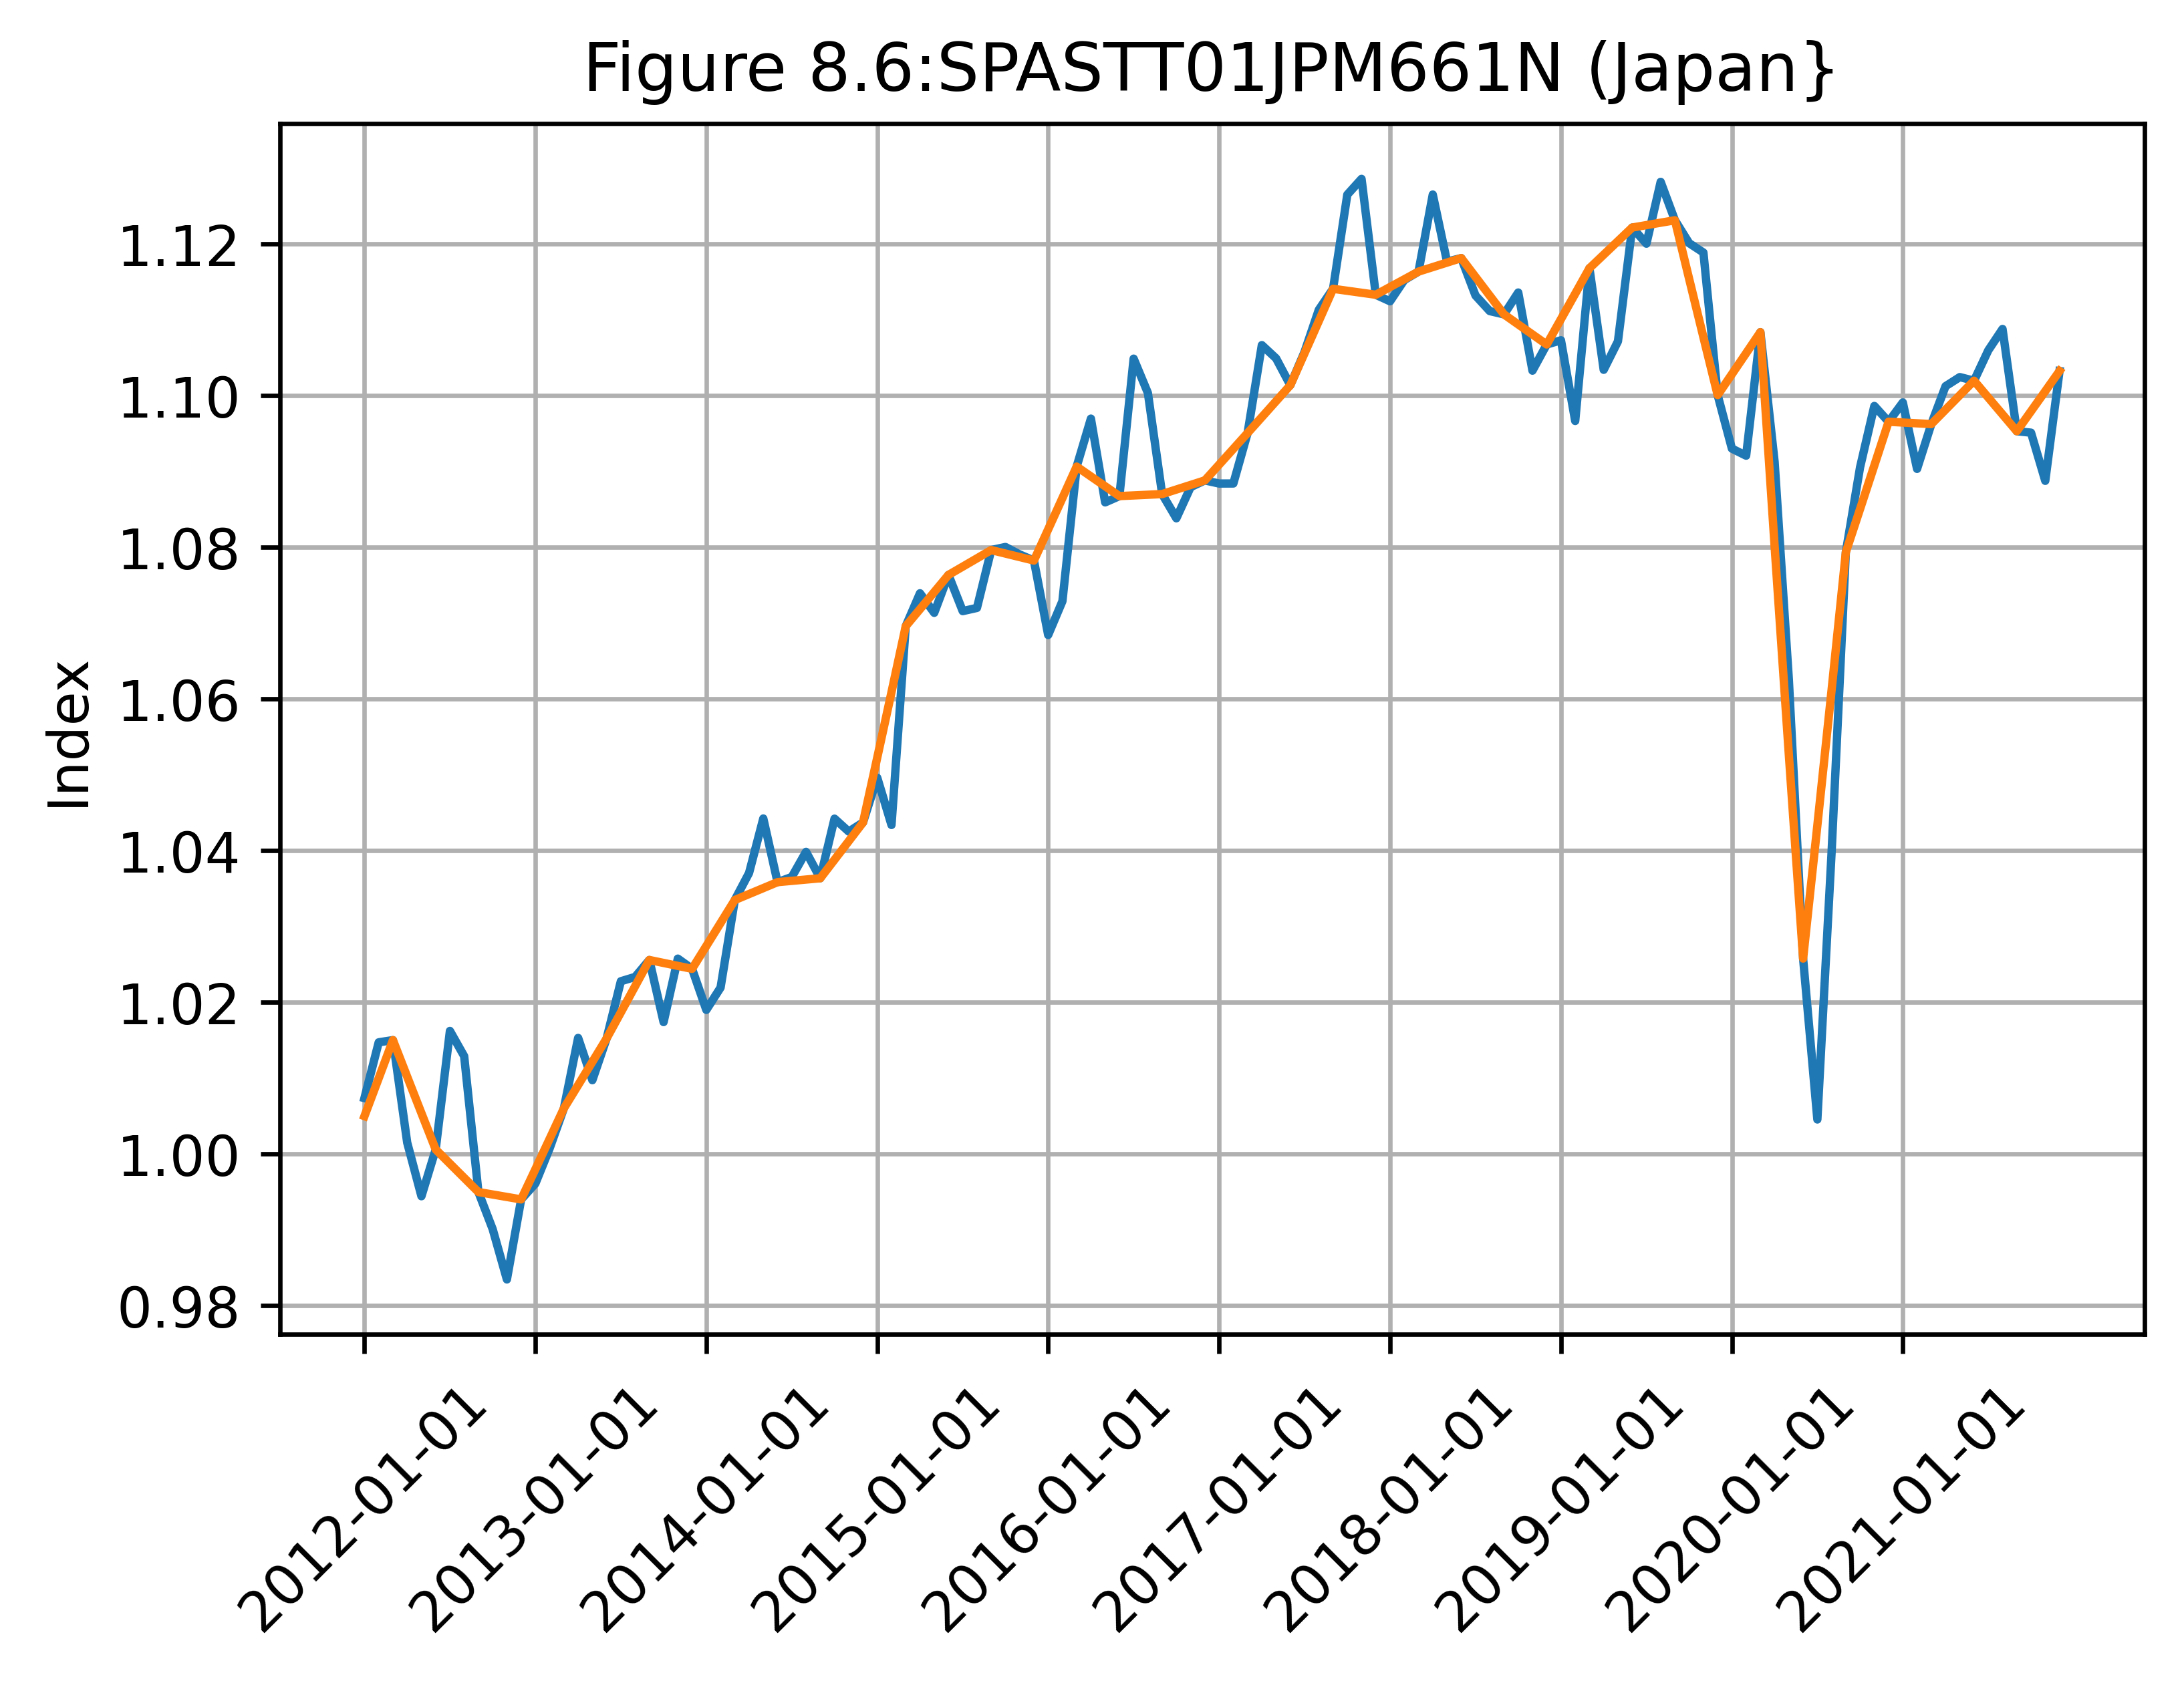

In [12]:
#Code Segment 8.10
#MCMC Gibbs Sampling to fill in missing data

need_data=True    #Indicator to make sure we got previous year's data
lastday=qf.LastYearEnd()

while need_data:    #Get most recent year available
    firstday_e=str(int(lastday[:4])-10)+'-10-01'  #Go back 10 years (quarterly)
    #Quarterly economic data US, Euro, Japan
    seriesnames=['GDP','EUNNGDP','JPNNGDP']
    cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=firstday_e,enddate=lastday)
    if not any(np.isnan(ratematrix[-1])):        #See if we got desired data
        need_data=False
    else:    #go back a year
        lastday=str(int(lastday[:4])-1)+lastday[-6:]    
    
#Get log-changes of GDP data
lgdates_e,difflgs_e=qf.levels_to_log_returns(cdates,ratematrix,[1,1,1])

#Monthly stock market data US, Euro, Japan
firstday_m=str(int(lastday[:4])-10)+'-09-01'  #Go back 10 years with quarter offset
seriesnames=['SPASTT01USM661N','SPASTT01EZM661N','SPASTT01JPM661N',]
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=firstday_m,enddate=lastday)
lgdates_m,difflgs_m=qf.levels_to_log_returns(cdates,ratematrix,[1,1,1])

#Compute parameters explained in text
n_m=len(difflgs_m[0])                         #Number of monthly series
n_e=len(difflgs_e[0])                         #Number of quarterly series
T_m=len(difflgs_m)-3                          #Number of months in monthly series
T_e=len(difflgs_e)                            #Number of quarters in quarterly series
D_m=np.array(difflgs_m[:-3])                  #Monthly data (n_m x T_m) (offset by a quarter)
D_e=np.array(difflgs_e)                       #Quarterly data (n_e x T_e)
mu_m=np.mean(D_m,axis=0)                      #Mean vector of monthly data
C_m=np.cov(D_m.T)                             #Covariance matrix of monthly data
mu_e=np.mean(D_e,axis=0)/3.                   #Month-ized mean vector of quarterly data
C_e=np.cov(D_e.T)/3.                          #Month-ized covariance matrix of quarterly data

#Monthly data quarter-ized and de-meaned
QD_m=[D_m[t]+D_m[t+1]+D_m[t+2]-3.*mu_m for t in range(0,T_m,3)]

#Market/economic covariance matrix
C_me=(list(zip(*QD_m)) @ (D_e-np.tile(3.*mu_e,(T_e,1))))/(3.*T_e)

#Conditional distribution covariance matrix
C_e_bar_m=C_e-((C_me.T @ np.linalg.inv(C_m)) @ C_me)

#Set up for Gibbs sampler
y=np.zeros((T_m,n_e))   #Output: pseudo-monthly economic series
z=np.zeros((T_m,n_e))   #pre-adjusted pseudo-monthly economic series

#Step 1
x_t=mu_e
t=1
done=False
while not done:
    #Step 2 (python indexing convention off one from text)
    z[t-1]=rng.multivariate_normal(x_t,C_e_bar_m)
    #Step 3
    if t % 3 == 0: # This is a quarter-end
        adjust = (D_e[int(t/3)-1]-(z[t-1]+z[t-2]+z[t-3]))/3.
        for q in range(1,4):
            y[t-q]=z[t-q]+adjust
    #Step 4
    x_t=mu_e+((C_me.T @ np.linalg.inv(C_m)) @ (D_m[t-1]-mu_m))
    t+=1
    done = (t > T_m)

#Plot quarterly economic series vs. monthly as index values
names=['US','Europe','Japan']
for e in range(n_e):
    yy=np.exp(np.cumsum(y[:,e]))
    dd=[[D_e[i][e]/3]*3 for i in range(T_e)]   #straight-line interpolate quarterly to monthly
    DD=np.exp(np.cumsum(dd))
    plt.plot(range(T_m),yy)
    plt.plot(range(T_m),DD)
    plt.ylabel('Index')
    plt.xticks(range(0,T_m,12),lgdates_m[3:][::12],rotation=45)
    str_title='Figure 8.%d:' % (e+4)
    str_title+=seriesnames[e]+' ('+names[e]+'}'
    plt.title(str_title)
    plt.grid()
    plt.show();

## Code segment 8.11  
Gibbs Sampler prediction in Section 8.4

In [12]:
#Code Segment 8.11
#Sum last 3 conditional means
x_t=0
for t in range(-1,-4,-1):
    x_t+=mu_e+((C_me.T @ np.linalg.inv(C_m)) @ (difflgs_m[-t]-mu_m))

print(f'Final quarterly mean vector for GDP log-changes, quarter ending {lastday}')
for e in range(n_e):
    print('{:9}: {:8.5}'.format(names[e],x_t[e]))

#Display conditional covariance matrix
print('\nConditional covariance matrix:')
for e in range(n_e):
    print('{:9.6} {:9.6} {:9.6}'.format(C_e_bar_m[e][0],C_e_bar_m[e][1],C_e_bar_m[e][2]))
    
#See if subsequent 1Q GDPs available    
newday=str(int(lastday[:4])+1)+'-01-01'
seriesnames=['GDP','EUNNGDP','JPNNGDP']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=lastday,enddate=newday)

#Show actual log-changes if available
print(f'\nActual log-changes of GDPs, first quarter {newday[:4]}')
for e in range(n_e):
    if not(np.isnan(ratematrix[-1][e])):
        lrt=np.log(ratematrix[-1][e]/ratematrix[0][e])
        print('{:9}: {:8.5}'.format(names[e],lrt))
    else:
        print('{:9}: Not available'.format(names[e]))

Final quarterly mean vector for GDP log-changes, quarter ending 2021-12-31
US       :  0.02218
Europe   : 0.017228
Japan    : 0.0056103

Conditional covariance matrix:
7.04025e-05 8.34427e-05 4.36161e-05
8.34427e-05 0.000119881 5.75181e-05
4.36161e-05 5.75181e-05 5.49502e-05



Actual log-changes of GDPs, first quarter 2022
US       : 0.015945
Europe   : 0.019657
Japan    : 0.0014907
